# Overview

This colab contains our attempt to convert the cycleGAN into a full tfx pipeline. 
* I was able to get the inital parts of loading the data and preprocessing it working. 
* I was able to generate statistics on the data as well
* Transforming data gave some trouble. I had issue writing a proper callback that was used by the framework.

Ran out of time. Will experiement with this over the summer!

In [2]:
import os
import pprint
import tempfile
import urllib
import argparse
from datetime import datetime

import absl
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.utils.dsl_utils import external_input


%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

The tfx.orchestration.experimental.interactive.notebook_extensions.skip extension is already loaded. To reload it, use:
  %reload_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip


In [3]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.1.0
TFX version: 0.21.4


In [10]:
current_dir = os.getcwd()

In [14]:
_tfx_root = tfx.__path__[0]
_serving_model_dir = current_dir + '\\saved_models'

In [21]:
_data_root = current_dir + '\\datasets' # os.path.join(os.getcwd(), '\\datasets')

In [22]:
_serving_model_dir

'D:\\Workdir\\DL_Project\\cycleGAN\\saved_models'

In [23]:
_data_root

'D:\\Workdir\\DL_Project\\cycleGAN\\datasets'

In [25]:
context = InteractiveContext()

# Load and Visualize Data

In [59]:
monet_tf_rec_data = current_dir + '\\tfrecords\\monet2photo'
monet_train_A = monet_data + '\\trainA.tfrecord'
real_train_B = monet_data + '\\trainB.tfrecord'

trainA/tfrecprd amd trainB.tfrecord simply contain a simple dump of all images.
This was performed using 
```
    with tf.io.TFRecordWriter(train_A_output) as writer:
        for file in train_A_files:
            example = convert_to_tfexample(file)
```

In [90]:
## Transform logic
def make_dataset(filepath):
    raw_dataset = tf.data.TFRecordDataset(filepath)

    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
    }

    def preprocess_image(encoded_image):
        image = tf.image.decode_jpeg(encoded_image, 3)
        # random flip left or right
        image = tf.image.random_flip_left_right(image)
        # resize to 286x286
        image = tf.image.resize(image, [286, 286])
        # random crop a 256x256 area
        image = tf.image.random_crop(
            image, [256, 256, tf.shape(image)[-1]])
        # normalize from 0-255 to -1 ~ +1
        image = image / 127.5 - 1
        return image

    def parse_image_function(example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        features = tf.io.parse_single_example(example_proto,
                                              image_feature_description)
        encoded_image = features['image/encoded']
        image = preprocess_image(encoded_image)
        return image

    parsed_image_dataset = raw_dataset.map(parse_image_function)
    return parsed_image_dataset

In [58]:
monet_parsed_data = make_dataset(monet_train_A)
real_parsed_data = make_dataset(real_train_B)

In [33]:
type(parsed_data)

tensorflow.python.data.ops.dataset_ops.MapDataset

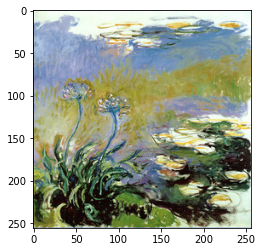

In [56]:
# View Tensorflow Encoded Data
for raw_record in raw_dataset.take(5):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    img_string = (example.features.feature['image/encoded'].bytes_list.value)[0]
    img_flat = tf.image.decode_jpeg(img_string).numpy()
    imshow(img_flat)

## Import Directly into ExampleGen

In [ ]:
from tfx.utils.dsl_utils import tfrecord_input
from tfx.components.example_gen.import_example_gen.component import ImportExampleGen

In [62]:
examples = external_input(monet_tf_rec_data) # Passing in both A and B examples!!
example_gen = ImportExampleGen(input=examples)

In [69]:
context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(type_name: Examples, uri: C:\Users\manme\AppData\Local\Temp\tfx-interactive-2020-05-16T18_22_01.410696-oa1bqp4l\ImportExampleGen\examples\1, id: 2)]
        ))

In [70]:
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] C:\Users\manme\AppData\Local\Temp\tfx-interactive-2020-05-16T18_22_01.410696-oa1bqp4l\ImportExampleGen\examples\1


In [72]:
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'train')

In [73]:
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

In [75]:
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [ ]:
for tfrecord in dataset.take(1):
    serialized_example = tfrecord.numpy()
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    img_string = (example.features.feature['image/encoded'].bytes_list.value)[0]
    img_flat = tf.image.decode_jpeg(img_string).numpy()

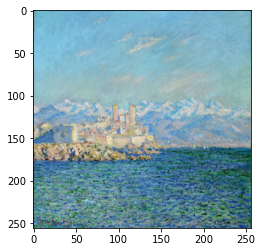

In [80]:
# Iterate over the first 1 records and decode them.
for tfrecord in dataset.take(1):
    serialized_example = tfrecord.numpy()
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    img_string = (example.features.feature['image/encoded'].bytes_list.value)[0]
    img_flat = tf.image.decode_jpeg(img_string).numpy()
    imshow(img_flat)

In [81]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen)

d:\workdir\conda_env\dl\lib\site-packages\tensorflow_data_validation\arrow\arrow_util.py:239: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  types.FeaturePath([column_name]), column.data.chunk(0), weights):


ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(type_name: ExampleStatistics, uri: C:\Users\manme\AppData\Local\Temp\tfx-interactive-2020-05-16T18_22_01.410696-oa1bqp4l\StatisticsGen\statistics\2, id: 3)]
        ))

In [82]:
%%skip_for_export

context.show(statistics_gen.outputs['statistics'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


This cell will be skipped during export to pipeline.


In [83]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(type_name: Schema, uri: C:\Users\manme\AppData\Local\Temp\tfx-interactive-2020-05-16T18_22_01.410696-oa1bqp4l\SchemaGen\schema\3, id: 4)]
        ))

In [84]:
%%skip_for_export

context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'image/encoded',BYTES,required,single,-
'image/filename',BYTES,required,single,-
'image/format',STRING,required,single,'image/format'
'image/height',INT,required,single,-
'image/width',INT,required,single,-


,Values
Domain,
'image/format','JPEG'


This cell will be skipped during export to pipeline.


In [85]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(type_name: ExampleAnomalies, uri: C:\Users\manme\AppData\Local\Temp\tfx-interactive-2020-05-16T18_22_01.410696-oa1bqp4l\ExampleValidator\anomalies\4, id: 5)]
        ))

In [86]:
%%skip_for_export

context.show(example_validator.outputs['anomalies'])

This cell will be skipped during export to pipeline.


In [88]:
_cycleGAN_constants_module_file = 'cGAN_constants.py'

In [95]:
%%skip_for_export
%%writefile {_cycleGAN_constants_module_file}

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

LEARNING_RATE = 0.0002
BETA_1 = 0.5
LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5
POOL_SIZE = 50
EPOCHS = 40
DECAY_EPOCHS = 100
SHUFFLE_SIZE = 10000



Overwriting cGAN_constants.py
This cell will be skipped during export to pipeline.


# Transform

In [96]:
_cGAN_transform_module_file = 'cGAN_transform.py'

In [98]:
%%skip_for_export
%%writefile {_taxi_transform_module_file}

import cGAN_constants
import tensorflow_transform as tft

outputs = {}
def preprocessing_fn(inputs):
    encoded_image = inputs['image/encoded']
    image = tf.image.decode_jpeg(encoded_image, 3)
    # random flip left or right
    image = tf.image.random_flip_left_right(image)
    # resize to 286x286
    image = tf.image.resize(image, [286, 286])
    # random crop a 256x256 area
    image = tf.image.random_crop(
        image, [256, 256, tf.shape(image)[-1]])
    # normalize from 0-255 to -1 ~ +1
    image = image / 127.5 - 1
    
return outputs

Writing {_taxi_transform_module_file}
This cell will be skipped during export to pipeline.


# Trainer

In [91]:
_cGAN_trainer_module_file = 'cGAN_trainer.py'

In [92]:
%%skip_for_export
%%writefile {_taxi_trainer_module_file}

from typing import List, Text

import os
import absl
import datetime
import tensorflow as tf
import tensorflow_transform as tft

from tfx.components.trainer.executor import TrainerFnArgs



Writing {_taxi_trainer_module_file}
This cell will be skipped during export to pipeline.
